# Chats Data Exploration

This notebook loads `chats.json`, displays it with pandas, and produces a few simple matplotlib visualizations. It tries to automatically find the file and adapt to common JSON structures (flat lists, nested messages, or line-delimited JSON).

In [1]:
# Imports and notebook setup
%matplotlib inline
import json
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 120)
plt.style.use('seaborn-v0_8')


In [2]:
# Locate the chats.json file
candidates = [
    Path('..') / 'project' / 'chats.json',
    Path('.') / 'chats.json',
    Path('..') / 'chats.json',
    Path('.') / 'Moptimizer' / 'task_1_UI' / 'project' / 'chats.json'
]
data_path = None
for p in candidates + list(Path('.').glob('**/chats.json')):
    if p.exists():
        data_path = p
        break

if data_path is None:
    raise FileNotFoundError('Could not find chats.json. Adjust the candidates or path as needed.')

print(f'Using chats.json at: {data_path.resolve()}')


Using chats.json at: C:\Users\USER\Desktop\bootcamp\Project\Moptimizer\task_1_UI\project\chats.json


In [3]:
# Load JSON into a pandas DataFrame (robust to common formats)
def load_chats_json(path: Path) -> pd.DataFrame:
    try:
        # Try standard JSON (array or object)
        return pd.read_json(path)
    except ValueError:
        pass
    try:
        # Try line-delimited JSON
        return pd.read_json(path, lines=True)
    except ValueError:
        pass
    # Fallback: use json.load then normalize
    with open(path, 'r', encoding='utf-8') as f:
        raw = json.load(f)
    return pd.json_normalize(raw)

df = load_chats_json(data_path)
print(f'DataFrame shape: {df.shape}')
df.head()


DataFrame shape: (5, 2)


,userId,messages
0,testUser,"[{'id': '1756385684066', 'role': 'user', 'cont..."
1,1756386246723,"[{'id': '1756386248757', 'role': 'user', 'cont..."
2,1756386299518,"[{'id': '1756386301336', 'role': 'user', 'cont..."
3,1756386644240,"[{'id': '1756386646755', 'role': 'user', 'cont..."
4,1756386853544,"[{'id': '1756386858433', 'role': 'user', 'cont..."


## Basic Summary

## Message-Level Analysis (if applicable)
Attempts to detect a nested messages list and compute simple stats like message length distribution and top senders.

In [ ]:
# Try to extract message-level records if a messages-like column exists
msg_df = None
message_keys = ['messages', 'message', 'msgs', 'items', 'data']
for k in message_keys:
    if k in df.columns and df[k].apply(lambda x: isinstance(x, list)).any():
        exploded = df[[k]].explode(k).dropna(subset=[k])
        try:
            msg_df = pd.json_normalize(exploded[k])
        except Exception:
            # If items are primitives, wrap in dict
            msg_df = exploded.rename(columns={k: 'value'})
        break

if msg_df is not None and not msg_df.empty:
    print(f'Message records detected: {len(msg_df)} rows')
    display(msg_df.head())
else:
    print('No nested messages list detected; using top-level DataFrame for plots.')
    msg_df = df.copy()


Message records detected: 18 rows


,id,role,content,timestamp,replyTo,rating
0,1756385684066,user,jj,2025-08-28T12:54:44.066Z,NaN,NaN
1,1756385684067,assistant,This is a simulated response.,2025-08-28T12:54:44.066Z,1756385684066,like
2,1756385687145,user,pp,2025-08-28T12:54:47.145Z,NaN,NaN
3,1756385687146,assistant,Your request has been received.,2025-08-28T12:54:47.145Z,1756385687145,None
4,1756385850550,user,jj,2025-08-28T12:57:30.550Z,NaN,NaN


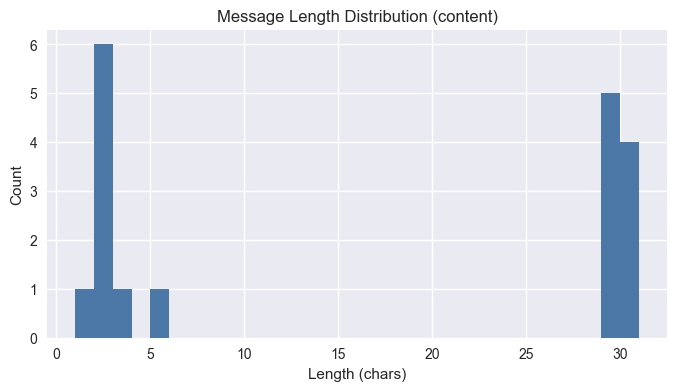

In [ ]:
# Choose a text column heuristically for length analysis
text_candidates = ['content', 'text', 'message', 'body', 'value']
text_col = None
for c in text_candidates:
    if c in msg_df.columns:
        text_col = c
        break

if text_col is None:
    # fallback: first object-type column
    obj_cols = [c for c in msg_df.columns if msg_df[c].dtype == 'object']
    text_col = obj_cols[0] if obj_cols else None

if text_col is not None:
    lengths = msg_df[text_col].astype(str).str.len()
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(lengths, bins=30, color='#4C78A8')
    ax.set_title(f'Message Length Distribution ({text_col})')
    ax.set_xlabel('Length (chars)')
    ax.set_ylabel('Count')
    plt.show()
else:
    print('Could not find a text-like column to analyze lengths.')


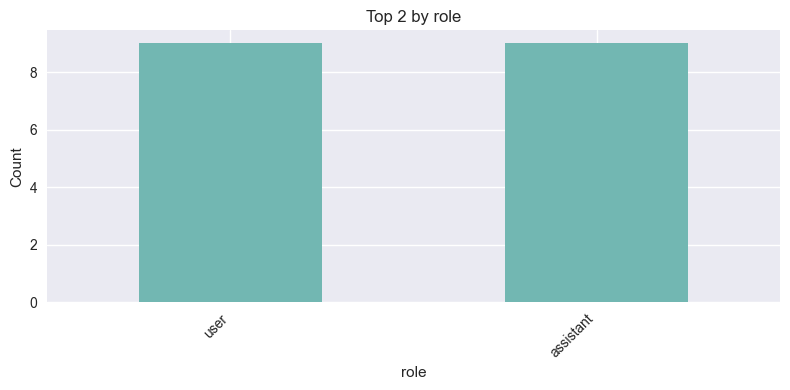

In [ ]:
# Top senders or roles, if such a column exists
sender_candidates = ['sender', 'role', 'author', 'user', 'from', 'name']
sender_col = None
for c in sender_candidates:
    if c in msg_df.columns:
        sender_col = c
        break

if sender_col is not None:
    top_counts = msg_df[sender_col].astype(str).value_counts().head(10)
    fig, ax = plt.subplots(figsize=(8, 4))
    top_counts.plot(kind='bar', ax=ax, color='#72B7B2')
    ax.set_title(f'Top {len(top_counts)} by {sender_col}')
    ax.set_xlabel(sender_col)
    ax.set_ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print('No sender/role-like column found for bar chart.')
